In [1]:
import numpy as np
import time
from datetime import datetime
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [2]:
dataset_folder_path = "Dataset_png" # 資料集資料夾名稱
dataset_file_list = os.listdir(dataset_folder_path) # 資料集圖片名稱
dataset_file_paths = [dataset_folder_path + "/" + i for i in dataset_file_list] # 圖片完整路徑
dataset_labels = np.zeros(len(dataset_file_paths))  # 存放labels陣列

In [3]:
# 利用檔案名稱建立labels
for i, file_path in enumerate(dataset_file_paths):
    if 'front' in file_path:
        label = 0
    elif 'back' in file_path:
        label = 1
    elif 'left' in file_path:
        label = 2
    elif 'right' in file_path:
        label = 3
    elif 'up' in file_path:
        label = 4
    else:
        label = 5
    dataset_labels[i] = label

# 將資料集依照 7:2:1 = 訓練:驗證:測試
train_paths, val_test_paths, train_labels, val_test_labels = train_test_split(dataset_file_paths, dataset_labels, test_size = 0.3, random_state = 42)
val_paths, test_paths, val_labels, test_labels = train_test_split(val_test_paths, val_test_labels, test_size = 1/3, random_state = 42)

# 對labels進行ont-hot編碼
train_labels  = torch.tensor(train_labels)
train_labels_onehot = torch.zeros(train_labels.shape[0], 6)
train_labels_onehot.scatter_(1, train_labels.long().unsqueeze(1), 1.0)

val_labels  = torch.tensor(val_labels)
val_labels_onehot = torch.zeros(val_labels.shape[0], 6)
val_labels_onehot.scatter_(1, val_labels.long().unsqueeze(1), 1.0) 

test_labels  = torch.tensor(test_labels)
test_labels_onehot = torch.zeros(test_labels.shape[0], 6)
test_labels_onehot.scatter_(1, test_labels.long().unsqueeze(1), 1.0)

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")
print(f"Test set size: {len(test_paths)}")

Training set size: 840
Validation set size: 240
Test set size: 120


In [4]:
width = 160    # 圖片寬度
height = 120    # 圖片長度

In [5]:
# 進行圖片尺寸處理 尚未標準化
preprocess_without_normalize = transforms.Compose([
    transforms.Resize([height, width]),
    transforms.ToTensor(),
])

def loader_without_normalize(path):
    img = Image.open(path)
    img_tensor = preprocess_without_normalize(img)
    return img_tensor

train_imgs = torch.stack([loader_without_normalize(path) for path in train_paths], dim = 3)
val_imgs = torch.stack([loader_without_normalize(path) for path in val_paths], dim = 3)
test_imgs = torch.stack([loader_without_normalize(path) for path in test_paths], dim = 3)

print(f"train_imgs shape : {train_imgs.shape}")
print(f"val_imgs shape : {val_imgs.shape}")
print(f"test_imgs shape : {test_imgs.shape}")

train_imgs shape : torch.Size([1, 120, 160, 840])
val_imgs shape : torch.Size([1, 120, 160, 240])
test_imgs shape : torch.Size([1, 120, 160, 120])


In [6]:
# 計算各資料集平均值、標準差
train_mean = train_imgs.view(1, -1).mean(dim=1)
train_std = train_imgs.view(1, -1).std(dim=1)

val_mean = val_imgs.view(1, -1).mean(dim=1)
val_std = val_imgs.view(1, -1).std(dim=1)

test_mean = test_imgs.view(1, -1).mean(dim=1)
test_std = test_imgs.view(1, -1).std(dim=1)

print("訓練集平均值:", train_mean)
print("訓練集標準差:", train_std)

print("驗證集平均值:", val_mean)
print("驗證集標準差:", val_std)

print("測試集平均值:", test_mean)
print("測試集標準差:", test_std)

訓練集平均值: tensor([0.2019])
訓練集標準差: tensor([0.2384])
驗證集平均值: tensor([0.1978])
驗證集標準差: tensor([0.2347])
測試集平均值: tensor([0.1871])
測試集標準差: tensor([0.2301])


In [7]:
# 設定圖片前處理、標準化
train_preprocess = transforms.Compose([
  transforms.Resize([height, width]),
  transforms.ToTensor(),
  transforms.Normalize(train_mean, train_std)
])

val_preprocess = transforms.Compose([
  transforms.Resize([height, width]),
  transforms.ToTensor(),
  transforms.Normalize(val_mean, val_std)
])

test_preprocess = transforms.Compose([
  transforms.Resize([height, width]),
  transforms.ToTensor(),
  transforms.Normalize(test_mean, test_std)
])

# 設定loader
def train_loader(path):
  img_pil = Image.open(path)
  img_tensor = train_preprocess(img_pil)
  img_tensor = torch.transpose(img_tensor, 2, 1)
  return img_tensor

def val_loader(path):
  img_pil = Image.open(path)
  img_tensor = val_preprocess(img_pil)
  img_tensor = torch.transpose(img_tensor, 2, 1)
  return img_tensor

def test_loader(path):
  img_pil = Image.open(path)
  img_tensor = test_preprocess(img_pil)
  img_tensor = torch.transpose(img_tensor, 2, 1)
  return img_tensor

In [8]:
# 訓練資料集
class Train_set(Dataset):
  def __init__(self, loader = train_loader):
    self.images = train_paths           # 設定圖片檔案路徑列表
    self.target = train_labels_onehot   # 設定標籤列表
    self.loader = loader                # 設定圖片載入器

  def __getitem__(self, index):
    fn = self.images[index]       # 取得指定索引的圖片檔案路徑
    img = self.loader(fn)         # 使用圖片載入器載入圖片
    target = self.target[index]   # 取得指定索引的標籤
    return img, target

  def __len__(self):
    return len(self.images)       # 用於取得資料集的大小
  
# 驗證資料集
class Val_set(Dataset):
  def __init__(self, loader = val_loader):
    self.images = val_paths
    self.target = val_labels_onehot
    self.loader = loader

  def __getitem__(self, index):
    fn = self.images[index]
    img = self.loader(fn)
    target = self.target[index]
    return img, target

  def __len__(self):
    return len(self.images)
  
# 測試資料集
class Test_set(Dataset):
  def __init__(self, loader = test_loader):
    self.images = test_paths
    self.target = test_labels_onehot
    self.loader = loader
  def __getitem__(self, index):
    fn = self.images[index]
    img = self.loader(fn)
    target = self.target[index]
    return img, target

  def __len__(self):
    return len(self.images)

In [9]:
# 使用資料集
train_data = Train_set()
val_data = Val_set()
test_data = Test_set()

batch_size = 60
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [10]:
# 使用GPU訓練
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [11]:
# LSTM 模型
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layer, n_class, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim    # 隱藏層
        self.n_layer = n_layer          # 記憶層
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first = True, dropout = dropout) # (輸入尺寸, 隱藏層, lstm層數, 批次優先, dropout機率)
        self.linear1 = nn.Linear(hidden_dim, int(hidden_dim / 2))    # 線性層
        self.linear2 = nn.Linear(int(hidden_dim / 2), n_class)       # 全連接層
 
    def forward(self, x):               
        out, _ = self.lstm(x)                   # LSTM 前向傳播
        out = out[:, -1, :]                     # 取出序列最後一個時間輸出
        out = torch.relu(self.linear1(out))     # 線性層
        out = self.linear2(out)                 # 全連接層
        return out

# 超參數
num_epochs = 250            # 迭代次數
learning_rate = 1e-4        # 學習率
step_size = 1               # 步長
gamma = 0.9                 # 下降率
input_dim = height          # 輸入
hidden_dim = height * 2     # 隱藏層層數
n_layer = 3                 # lstm層數
n_class = 6                 # 輸出類別
dropout = 0.4               # dropout機率

model = LSTM(input_dim, hidden_dim, n_layer, n_class, dropout)     # (輸入尺寸, 隱藏層, lstm層數, 輸出類別, dropout機率)
criterion = nn.CrossEntropyLoss()                                  # 設定計算loss
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)                      # 優化器
# lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)     # 學習率步階下降
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  
ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gamma)


In [12]:
# 儲存歷史資料
train_loss_history = []         # 訓練集loss
val_loss_history = []           # 驗證集loss
train_accuracy_history = []     # 訓練集準確率
val_accuracy_history = []       # 驗證集準確率
start_time = time.time()        # 訓練起始時間

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # 單次迭代起始時間

    # 訓練模式
    total_train_loss = 0.0
    num_train_batches = 0
    train_correct = 0
    train_total = 0

    for (imgs, labels) in train_loader:
        imgs = imgs.reshape(-1, width, height).to(device = device)
        labels = labels.to(device = device)
        model.to(device = device)
        model.train()
        outputs = model(imgs)
        train_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # 計算總數與正確個數
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # 計算單次損失
        total_train_loss += train_loss.item()
        num_train_batches += 1
    
    # 計算此次迭代平均loss
    avg_train_loss = total_train_loss / num_train_batches 
    # 計算此次迭代平均準確率
    avg_train_accuracy = train_correct / train_total
    # 新增至歷史資料陣列
    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(avg_train_accuracy)

    # 驗證模式
    total_val_loss = 0.0
    num_val_batches = 0
    val_correct = 0
    val_total = 0

    for (imgs, labels) in val_loader:
        imgs = imgs.reshape(-1, width, height).to(device = device)
        labels = labels.to(device = device)
        model.to(device = device)
        model.eval()
        outputs = model(imgs)
        val_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim = 1)
        labels = torch.argmax(labels, dim = 1)
        
        # 計算總數與正確個數
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

        # 計算單次損失
        total_val_loss += val_loss.item()
        num_val_batches += 1

    # 計算此次迭代平均loss
    avg_val_loss = total_val_loss / num_val_batches
    # 計算此次迭代平均準確率
    avg_val_accuracy = val_correct / val_total
    # 新增至歷史資料陣列
    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(avg_val_accuracy)
    
    # 印出此次迭代資料
    epoch_time = time.time() - epoch_start_time
    print('Epoch: {:<2d} | Train Loss: {:.6f} | Val Loss: {:.4f} | Train Accuracy: {:.6f} | Val Accuracy: {:.4f} | Time: {:.2f} s'
          .format(epoch + 1, avg_train_loss, avg_val_loss, avg_train_accuracy, avg_val_accuracy, epoch_time))

# 此次訓練時長
total_time = time.time() - start_time
print('Training complete! Total time: {:.2f} s'.format(total_time))

Epoch: 1  | Train Loss: 1.787455 | Val Loss: 1.7825 | Train Accuracy: 0.210714 | Val Accuracy: 0.2417 | Time: 3.69 s
Epoch: 2  | Train Loss: 1.775822 | Val Loss: 1.7658 | Train Accuracy: 0.238095 | Val Accuracy: 0.2417 | Time: 3.40 s
Epoch: 3  | Train Loss: 1.755806 | Val Loss: 1.7309 | Train Accuracy: 0.239286 | Val Accuracy: 0.2500 | Time: 3.64 s
Epoch: 4  | Train Loss: 1.723239 | Val Loss: 1.6902 | Train Accuracy: 0.246429 | Val Accuracy: 0.2792 | Time: 3.67 s
Epoch: 5  | Train Loss: 1.688456 | Val Loss: 1.6505 | Train Accuracy: 0.308333 | Val Accuracy: 0.3500 | Time: 3.67 s
Epoch: 6  | Train Loss: 1.640908 | Val Loss: 1.5855 | Train Accuracy: 0.361905 | Val Accuracy: 0.3583 | Time: 3.66 s
Epoch: 7  | Train Loss: 1.576095 | Val Loss: 1.5231 | Train Accuracy: 0.364286 | Val Accuracy: 0.3542 | Time: 3.66 s
Epoch: 8  | Train Loss: 1.526336 | Val Loss: 1.4876 | Train Accuracy: 0.359524 | Val Accuracy: 0.3625 | Time: 3.75 s
Epoch: 9  | Train Loss: 1.484893 | Val Loss: 1.4385 | Train Accu

KeyboardInterrupt: 

In [ ]:
# 使用測試集進行準確率計算
def calculate_accuracy(model, data_loader, device):
    model.eval()  # 將模型設為評估模式
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.reshape(-1, width, height).to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            labels = torch.argmax(labels, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print("Accuracy: {:.2f}".format(accuracy))
    
    return accuracy

test_accuracy = calculate_accuracy(model, test_loader, device)

Accuracy: 0.92


In [ ]:
# 創建資料夾記錄訓練資料
current_time = datetime.now().strftime("%Y%m%d_%H%M")
folder_name = f"訓練資料/LSTM_直向訓練_{current_time}"
os.makedirs(folder_name)
print(f"已創建資料夾: {folder_name}")


已創建資料夾: 訓練資料/LSTM_直向訓練_20240103_2353


In [ ]:
# 儲存模型
file_path = os.path.join(folder_name, 'model.pt')
torch.save(model, file_path)

損失趨勢圖儲存至: 訓練資料/LSTM_直向訓練_20240103_2353\loss_plot.png


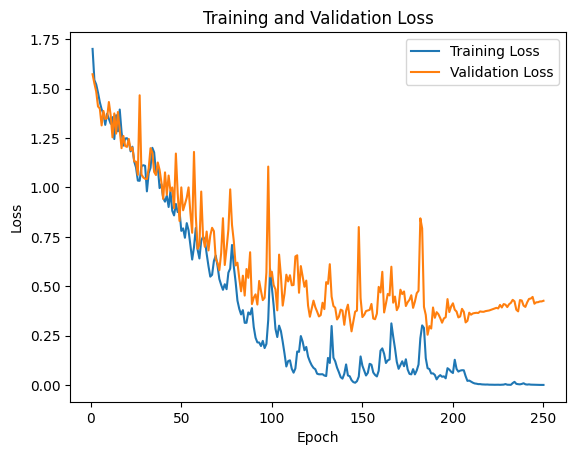

In [ ]:
# 畫出損失趨勢圖、並儲存
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

file_path = os.path.join(folder_name, 'loss_plot.png')
plt.savefig(file_path)
print(f"損失趨勢圖儲存至: {file_path}")

plt.show()

準確率趨勢圖儲存至: 訓練資料/LSTM_直向訓練_20240103_2353\Accuracy_plot.png


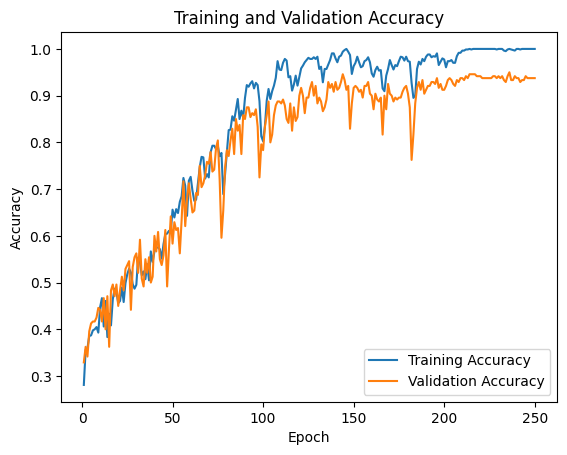

In [ ]:
# 畫出準確率趨勢圖、並儲存
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

file_path = os.path.join(folder_name, 'Accuracy_plot.png')
plt.savefig(file_path)
print(f"準確率趨勢圖儲存至: {file_path}")

plt.show()

In [ ]:
# 利用csv紀錄訓練資訊
csv_file_path = os.path.join(folder_name, 'training_results.csv')
csvFile = open(csv_file_path, 'w', newline = '')
writer = csv.writer(csvFile)

writer.writerow(['Train_set size', len(train_paths)])
writer.writerow(['Val_set size', len(val_paths)])
writer.writerow(['Test_set size', len(test_paths)])
writer.writerow(['Batch size', batch_size])
writer.writerow(['Width', width])
writer.writerow(['height', height])
writer.writerow(['Num_epochs', num_epochs])
writer.writerow(['Model', f'LSTM({input_dim}, {hidden_dim}, {n_layer}, {n_class}, {dropout})'])
writer.writerow(['Optimizer', f'torch.optim.Adam(model.parameters(), lr = {learning_rate})'])
# writer.writerow(['Learing rate', f'torch.optim.lr_scheduler.StepLR(optimizer, step_size = {step_size}, gamma = {gamma})'])
writer.writerow(['Learing rate', f'ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = {gamma})'])

writer.writerow([])

writer.writerow(['Epoch', 'Train_loss', 'Val_loss', 'Train_accuracy', 'Val_accuracy'])

for i in range(1, num_epochs + 1):
    writer.writerow([
        '{:<5}'.format(i),
        '{:<10}'.format(round(train_loss_history[i-1], 5)) if train_loss_history else None,
        '{:<10}'.format(round(val_loss_history[i-1], 5)) if val_loss_history else None,
        '{:<15}'.format(round(train_accuracy_history[i-1], 5)) if train_accuracy_history else None,
        '{:<15}'.format(round(val_accuracy_history[i-1], 5)) if val_accuracy_history else None
    ])

writer.writerow([])
writer.writerow(['Test_accuracy', test_accuracy])

csvFile.close()